In [55]:
import pandas as pd
from datetime import datetime, time
import seaborn as sns
import numpy as np
import scipy.stats

In [56]:
#считываю данные

In [57]:
support_tickets = pd.read_csv('D:\\Проекты\\тестовое\\авито\\support_tickets.csv',sep=',')
support_tickets.head(3)

user_id      ticket_category ticket_subcategory current_state  \
0  370 518 212  Технические вопросы     Доступ к сайту        Решено   
1    2 138 799  Технические вопросы     Доступ к сайту        Решено   
2    2 033 101  Технические вопросы     Доступ к сайту        Решено   

                             request_id    activity_start_dt  \
0  045be6ac-d532-4c20-b1c9-fb82c1737464  2015-11-26 22:56:00   
1  8ebbb8c6-7abb-4fad-a83b-35a71a83a186  2015-12-18 08:52:00   
2  ee303751-4a21-4544-a4c3-56924c088028  2015-12-16 19:06:00   

      fact_reaction_dt  
0  2015-12-03 12:11:00  
1  2015-12-23 06:40:00  
2  2015-12-26 07:46:00

In [58]:
new_items_by_support_users = pd.read_csv('D:\\Проекты\\тестовое\\авито\\new_items_by_support_users.csv',sep=',')
new_items_by_support_users.head(3)

user_id user_registration_time user_first_listing_date  \
0    386 341 477    2013-05-27 14:40:09     2013-05-27 14:40:09   
1  6 790 750 024    2013-12-14 23:05:15     2013-12-14 23:27:04   
2      2 755 740    2011-04-14 17:54:40     2011-04-14 18:05:27   

         item_id       item_starttime item_category       item_subcategory  
0  8 523 500 011  2014-01-01 02:22:54     Транспорт             Автомобили  
1  8 525 000 013  2014-01-01 02:45:56     Транспорт  Запчасти и аксессуары  
2  8 527 000 043  2014-01-01 03:29:44     Транспорт             Автомобили

In [59]:
users_evaluation_of_satisfaction = pd.read_csv('D:\\Проекты\\тестовое\\авито\\users_evaluation_of_satisfaction.csv',sep=',')
users_evaluation_of_satisfaction.head(3)

request_id result_mentioned_by_user
0  09e34912-b4df-4e91-b3e0-35b40fe6b9b8     Не удовлетворительно
1  76099bef-7ab3-4a01-96c3-4c06f4032a7e     Не удовлетворительно
2  70acfed6-8897-4e38-a407-65150e7a4395        Удовлетворительно

In [60]:
# ПОДГОТОВКА ДАННЫХ

In [61]:
#удаление дубликатов
support_tickets = support_tickets.drop_duplicates()

In [62]:
new_items_by_support_users = new_items_by_support_users.drop_duplicates()

In [63]:
users_evaluation_of_satisfaction = users_evaluation_of_satisfaction.drop_duplicates()

In [64]:
# функция для удаления пробелов и преобразования в int
def convert_currency(val):
    new_val = val.replace('\xa0', '').replace(' ', '')
    return int(new_val)

In [65]:
# преобразование к нужному типу данных

In [66]:
support_tickets['user_id'] = support_tickets['user_id'].apply(convert_currency)

In [67]:
support_tickets['activity_start_dt'] = pd.to_datetime(support_tickets['activity_start_dt'])

In [68]:
support_tickets['fact_reaction_dt'] = pd.to_datetime(support_tickets['fact_reaction_dt'])

In [69]:
new_items_by_support_users['user_id'] = new_items_by_support_users['user_id'].apply(convert_currency)

In [70]:
new_items_by_support_users['item_id'] = new_items_by_support_users['item_id'].apply(convert_currency)

In [71]:
new_items_by_support_users['item_starttime'] = pd.to_datetime(new_items_by_support_users['item_starttime'])

In [72]:
#присвоение оценке пользователя числового значения

In [73]:
users_evaluation_of_satisfaction.result_mentioned_by_user.unique()

array(['Не удовлетворительно', 'Удовлетворительно', 'Отлично', 'Хорошо',
       'Нейтрально'], dtype=object)

In [74]:
# функция присвоения числового значения оценке
def Mark(x):
    if x == 'Отлично':
        y = 5
    elif x == 'Хорошо':
        y = 4
    elif x == 'Нейтрально':
        y = 3
    elif x == 'Удовлетворительно':
        y = 2
    else:
        y = 1
    return(y)

In [75]:
users_evaluation_of_satisfaction['users_mark'] = users_evaluation_of_satisfaction['result_mentioned_by_user'].apply(Mark)

In [174]:
users_evaluation_of_satisfaction.tail()

request_id result_mentioned_by_user  \
217528  28a480ed-82e7-4f90-9cd3-ed4c169bafc9                   Хорошо   
217529  d2629148-958e-467c-8be6-8b8c5648b6a3                  Отлично   
217530  d220c543-49c4-4f83-b21e-641a6a5deae3     Не удовлетворительно   
217531  ae09fb6b-0e17-41fd-b8b2-b8aad4631812                  Отлично   
217532  8517db97-199f-4974-aa40-27f3d95bf0e9                  Отлично   

        users_mark  
217528           4  
217529           5  
217530           1  
217531           5  
217532           5

In [77]:
#объединение таблиц support_tickets и users_evaluation_of_satisfaction
support_tickets = support_tickets.merge(users_evaluation_of_satisfaction, how = 'left', on = 'request_id')

In [78]:
#расчет времени между заявкой и ответом специалиста поддержки
support_tickets['time'] = support_tickets.fact_reaction_dt - support_tickets.activity_start_dt

In [79]:
# удаление ошибок (ответ от поддержки произошел раньше, чем обращение в поддержку)
support_tickets.drop(support_tickets[support_tickets['fact_reaction_dt'] < support_tickets['activity_start_dt']].index, inplace=True)

In [80]:
# перевод ['time'] в секунды
support_tickets['time'] = support_tickets['time'] / np.timedelta64(1, 's')

In [81]:
#группировка по пользователю
support_feature = support_tickets.groupby('user_id', as_index = False).agg({'request_id' : 'count', 'users_mark' : 'mean', 'activity_start_dt' : 'min', 'time' : 'mean'}).sort_values(by=['request_id'])

In [82]:
support_feature.head(3)

user_id  request_id  users_mark   activity_start_dt      time
0                11           1         5.0 2015-10-01 10:06:00     420.0
189773  58139500282           1         NaN 2015-09-14 10:21:00    2520.0
189774  58140250286           1         NaN 2015-10-09 09:54:00  294060.0

In [83]:
#переименование столбцов
support_feature = support_feature.rename(columns={"request_id": "count_of_complaints", "time": "avg_time", "activity_start_dt" : "first_request_date", "users_mark" : "avg_users_mark"}).sort_values(by=['count_of_complaints'])
support_feature.head(3)

user_id  count_of_complaints  avg_users_mark  first_request_date  \
0             11                    1             5.0 2015-10-01 10:06:00   
63412  367879587                    1             5.0 2015-09-05 18:25:00   
63414  367879718                    1             NaN 2015-11-16 07:56:00   

       avg_time  
0         420.0  
63412    6240.0  
63414  642480.0

In [84]:
support_feature.shape

(298952, 5)

In [85]:
total = new_items_by_support_users.merge(support_feature, how = 'left', on = 'user_id')

In [86]:
total_after = total[total['item_starttime'] >= total['first_request_date']].groupby('user_id',  as_index = False).agg({'item_id' : 'count'})
total_after.head(3)

user_id  item_id
0       11       22
1       20       20
2       33        6

In [87]:
total_after = total_after.rename(columns={"item_id": "count_item_after"})

In [88]:
total_before = total[total['item_starttime'] < total['first_request_date']].groupby('user_id',  as_index = False).agg({'item_id' : 'count'})

In [89]:
total_before = total_before.rename(columns={"item_id": "count_item_before"})

In [90]:
total_after_before = total_before.merge(total_after, how = 'outer', on = 'user_id')
total_after_before.head(3)

user_id  count_item_before  count_item_after
0       11              391.0              22.0
1       20               62.0              20.0
2       33               10.0               6.0

In [91]:
total_after_before = total_after_before.fillna(0)

In [92]:
total = total.groupby('user_id', as_index = False).agg({'item_id' : 'count', 'count_of_complaints' : 'min', 'avg_users_mark' : 'min', 'avg_time' : 'min', 'user_registration_time' : 'min', 'first_request_date' : 'min', 'item_starttime' : 'max'})

In [93]:
total = total.rename(columns={"item_id" : "total_item", "item_starttime" : "Last_item_starttime"})

In [94]:
total['user_registration_time'] = pd.to_datetime(total['user_registration_time'])

In [100]:
total = total.merge(total_after_before, how = 'left', on = 'user_id')

In [101]:
total.head(3)

user_id  total_item  count_of_complaints  avg_users_mark  avg_time  \
0       11         413                  1.0             5.0     420.0   
1       20          82                  2.0             NaN  102750.0   
2       33          16                  2.0             5.0   67260.0   

  user_registration_time  first_request_date Last_item_starttime  \
0    2007-11-23 14:07:34 2015-10-01 10:06:00 2016-03-30 09:40:38   
1    2008-01-07 18:05:34 2015-09-03 15:19:00 2016-03-19 11:47:12   
2    2008-02-05 16:37:35 2015-09-30 13:10:00 2016-01-26 12:32:27   

   count_item_before  count_item_after  
0              391.0              22.0  
1               62.0              20.0  
2               10.0               6.0

In [108]:
total['Month_before'] = total.first_request_date - total.user_registration_time

In [113]:
total['Month_before'] = total['Month_before'] / np.timedelta64(1, 'M')

In [116]:
total['Month_after'] = total.Last_item_starttime - total.first_request_date

In [117]:
total['Month_after'] = total['Month_after'] / np.timedelta64(1, 'M')

In [119]:
total['avg_count_after'] = total.count_item_after / total.Month_after

In [142]:
total['avg_count_before'] = total.count_item_before / total.Month_before

In [121]:
total = total.loc[total['avg_time'] != 0]

In [192]:
total['avg_before'] = total['avg_count_before'].abs()

In [193]:
total['avg_after'] = total['avg_count_after'].abs()

In [188]:
total['Diff_avg'] = total.avg_count_after - total.avg_count_before

In [189]:
total['ratio'] = total.avg_count_after / total.avg_count_before

In [156]:
total.head(3)

user_id  total_item  count_of_complaints  avg_users_mark  avg_time  \
0       11         413                  1.0             5.0     420.0   
1       20          82                  2.0             NaN  102750.0   
2       33          16                  2.0             5.0   67260.0   

  user_registration_time  first_request_date Last_item_starttime  \
0    2007-11-23 14:07:34 2015-10-01 10:06:00 2016-03-30 09:40:38   
1    2008-01-07 18:05:34 2015-09-03 15:19:00 2016-03-19 11:47:12   
2    2008-02-05 16:37:35 2015-09-30 13:10:00 2016-01-26 12:32:27   

   count_item_before  count_item_after  Month_before  Month_after  \
0              391.0              22.0     94.255151     5.946155   
1               62.0              20.0     91.858456     6.500435   
2               10.0               6.0     91.791810     3.876020   

   avg_count_after  avg_count_before  Diff_avg_before_after  \
0         3.699870          4.148314               0.448445   
1         3.076717          0.674951              -2.401766   
2         1.547980          0.108942              -1.439038   

   ratio_avg_after_before  
0                0.891897  
1                4.558427  
2               14.209187

In [220]:
total = total.groupby('user_id', as_index = False).agg({'total_item' : 'min', 'count_of_complaints' : 'min', 'avg_users_mark' : 'min','avg_time' : 'min', 'count_item_before' : 'min', 'count_item_after' : 'min', 'avg_before' : 'min', 'avg_after' : 'min', 'Diff_avg' : 'min', 'ratio' : 'min'})

In [221]:
total.head()

user_id  total_item  count_of_complaints  avg_users_mark  avg_time  \
0       11         413                  1.0             5.0     420.0   
1       20          82                  2.0             NaN  102750.0   
2       33          16                  2.0             5.0   67260.0   
3       42         232                  2.0             NaN    2550.0   
4       44        1581                  1.0             3.0  147720.0   

   count_item_before  count_item_after  avg_before  avg_after   Diff_avg  \
0              391.0              22.0    4.148314   3.699870  -0.448445   
1               62.0              20.0    0.674951   3.076717   2.401766   
2               10.0               6.0    0.108942   1.547980   1.439038   
3              232.0               0.0    2.548298   0.000000  -2.548298   
4             1392.0             189.0   14.764665  59.116334  44.351669   

       ratio  
0   0.891897  
1   4.558427  
2  14.209187  
3   0.000000  
4   4.003906

In [202]:
total['ratio_log'] = np.log(total.ratio)

C:\Users\ippol\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [214]:
total['avg_time_log'] = np.log(total.avg_time)

In [218]:
sns.scatterplot(x="ratio_log", y="avg_time_log", data=total)

In [ ]:
[(total.ratio < 10.75) & (total.avg_time < 10000000)]

In [ ]:
[(total.avg_time < 500000)]

In [ ]:
#[(total.avg_time < 500000)]

In [176]:
total['ratio_avg_after_before_log'] = np.log(total.ratio_avg_after_before)

C:\Users\ippol\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
total['Diff_avg_before_after_log'] = np.log(total.Diff_avg_before_after)

In [222]:
total.corr()

user_id  total_item  count_of_complaints  \
user_id              1.000000   -0.040886            -0.005987   
total_item          -0.040886    1.000000             0.036790   
count_of_complaints -0.005987    0.036790             1.000000   
avg_users_mark       0.011161   -0.021222            -0.040323   
avg_time             0.011869    0.002941            -0.007517   
count_item_before   -0.047997    0.961832             0.030358   
count_item_after     0.000874    0.600087             0.036773   
avg_before           0.094216    0.033854             0.000203   
avg_after            0.023881    0.013625            -0.002178   
Diff_avg            -0.014806   -0.000656            -0.002093   
ratio               -0.015284   -0.003820            -0.002633   

                     avg_users_mark  avg_time  count_item_before  \
user_id                    0.011161  0.011869          -0.047997   
total_item                -0.021222  0.002941           0.961832   
count_of_complaints       -0.040323 -0.007517           0.030358   
avg_users_mark             1.000000 -0.123175          -0.023194   
avg_time                  -0.123175  1.000000           0.003793   
count_item_before         -0.023194  0.003793           1.000000   
count_item_after          -0.006846 -0.001054           0.358288   
avg_before                -0.006267  0.006295           0.030897   
avg_after                  0.004487 -0.007336           0.008447   
Diff_avg                   0.006663 -0.009247          -0.004286   
ratio                      0.004557 -0.006141          -0.003551   

                     count_item_after  avg_before  avg_after  Diff_avg  \
user_id                      0.000874    0.094216   0.023881 -0.014806   
total_item                   0.600087    0.033854   0.013625 -0.000656   
count_of_complaints          0.036773    0.000203  -0.002178 -0.002093   
avg_users_mark              -0.006846   -0.006267   0.004487  0.006663   
avg_time                    -0.001054    0.006295  -0.007336 -0.009247   
count_item_before            0.358288    0.030897   0.008447 -0.004286   
count_item_after             1.000000    0.025180   0.021793  0.010292   
avg_before                   0.025180    1.000000   0.011311 -0.381057   
avg_after                    0.021793    0.011311   1.000000  0.920182   
Diff_avg                     0.010292   -0.381057   0.920182  1.000000   
ratio                       -0.002663   -0.001846   0.538302  0.492655   

                        ratio  
user_id             -0.015284  
total_item          -0.003820  
count_of_complaints -0.002633  
avg_users_mark       0.004557  
avg_time            -0.006141  
count_item_before   -0.003551  
count_item_after    -0.002663  
avg_before          -0.001846  
avg_after            0.538302  
Diff_avg             0.492655  
ratio                1.000000

In [ ]:
[(total.count_of_items < 5000) & (total.avg_time < 2000000)]

In [ ]:
[(total.ratio_avg_after_before < 10.9) & (total.avg_time < 10000000)]

In [101]:
total_with_marks = total.query('avg_users_mark != "NaN"')

In [102]:
total_without_NaN.head(3)

user_id  count_of_items  count_of_complaints  avg_users_mark  avg_time  \
0       11              22                  1.0             5.0     420.0   
2       33               6                  2.0             5.0   67260.0   
3       44             189                  1.0             3.0  147720.0   

   count_of_items_log  avg_time_log  
0            3.091042      6.040255  
2            1.791759     11.116321  
3            5.241747     11.903074

In [103]:
total['count_of_items_log'] = np.log(total.count_of_items)

In [104]:
total['avg_time_log'] = np.log(total.avg_time)

In [128]:
sns.scatterplot(x="count_of_items", y="avg_time_log", data=total[(total.count_of_items < 5000) & (total.avg_time < 2000000)])

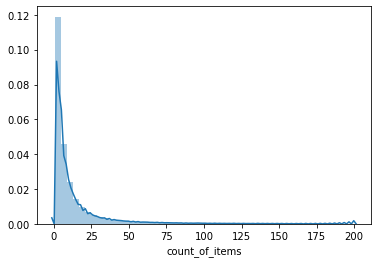

In [133]:
sns.distplot(total.count_of_items[total.count_of_items < 200])

In [ ]:
#[(total.count_of_items < 5000) & (total.avg_time < 2000000)]

In [111]:
scipy.stats.spearmanr(total.avg_time_log, total.count_of_items_log)

SpearmanrResult(correlation=-0.011612378966608324, pvalue=4.927513346486806e-07)

In [112]:
scipy.stats.spearmanr(total.avg_time_log, total.count_of_items)

SpearmanrResult(correlation=-0.011612378966608324, pvalue=4.927513346486806e-07)

In [113]:
scipy.stats.spearmanr(total.avg_time, total.count_of_items)

SpearmanrResult(correlation=-0.011612378966608324, pvalue=4.927513346486806e-07)

In [129]:
total_without_NaN[(total.count_of_items < 5000) & (total.avg_time < 2000000)].corr()

<ipython-input-129-26ee59fcd01e>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  total_without_NaN[(total.count_of_items < 5000) & (total.avg_time < 2000000)].corr()


user_id  count_of_items  count_of_complaints  \
user_id              1.000000       -0.001922            -0.001683   
count_of_items      -0.001922        1.000000             0.073365   
count_of_complaints -0.001683        0.073365             1.000000   
avg_users_mark       0.008386       -0.011852            -0.041838   
avg_time             0.029058       -0.004242            -0.013464   
count_of_items_log  -0.071002        0.456725             0.097305   
avg_time_log         0.020698        0.010695             0.026415   

                     avg_users_mark  avg_time  count_of_items_log  \
user_id                    0.008386  0.029058           -0.071002   
count_of_items            -0.011852 -0.004242            0.456725   
count_of_complaints       -0.041838 -0.013464            0.097305   
avg_users_mark             1.000000 -0.143094           -0.031565   
avg_time                  -0.143094  1.000000           -0.016412   
count_of_items_log        -0.031565 -0.016412            1.000000   
avg_time_log              -0.160432  0.691895            0.008548   

                     avg_time_log  
user_id                  0.020698  
count_of_items           0.010695  
count_of_complaints      0.026415  
avg_users_mark          -0.160432  
avg_time                 0.691895  
count_of_items_log       0.008548  
avg_time_log             1.000000

In [116]:
total.count_of_items.describe()

count    187550.000000
mean         22.010664
std         196.466337
min           1.000000
25%           2.000000
50%           5.000000
75%          13.000000
max       41582.000000
Name: count_of_items, dtype: float64